# Linear Models in Machine Learning on Python - Support Vector Machines 3

Welcome to the third notebook on SVM. In this notebook, we practice the algorithms that I introduced in the previous two notebooks. We will first use SVM on Australian Rain Dataset to see if SVM gives us a better result compared to logistic regression. Then we will use SVM on another binary classification problem. Lastly, we will use SVM for multiclass classification.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import warnings
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore', module='sklearn')
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC,SVC,NuSVC

In [ ]:
def plot_confusion(y,y_pred):
    if isinstance(y_pred, (np.ndarray)):
        plt.figure(figsize=(10, 7))
        cm=confusion_matrix(y, y_pred)
        
        plt.figure(figsize=(10, 7))
        group_names =['TN','FS','FN','TP']
        
        group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
        group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]

        labels = [f'{v1}\n\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
    
        sns.heatmap(cm, annot=labels, fmt='', cmap='mako',annot_kws={"fontsize":20})

    else:
        
        f, axes = plt.subplots(1, 3,figsize=(18,5))
        for i in range(3):
            cm=confusion_matrix(y, y_pred[i])
            plt.figure(figsize=(10, 7))
            group_names =['TN','FS','FN','TP']
            group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
            group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
            labels = [f'{v1}\n\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
            labels = np.asarray(labels).reshape(2,2)
            sns.heatmap(cm, annot=labels, fmt='', cmap='mako',annot_kws={"fontsize":20},ax=axes[i])

In [ ]:
def plot_precisionvsrecall(y,y_pred):
    if isinstance(y_pred, (np.ndarray)):
        plt.figure(figsize=(10, 7))
        precisions, recalls, thresholds = precision_recall_curve(y, y_pred)
        sns.set_style("darkgrid")
        ax=sns.lineplot(x=precisions, y=recalls ,linewidth = 2)
        ax.set_xlabel("Precision",fontsize=15)
        ax.set_ylabel("Recall",fontsize=15)
        ax.text(0.7 * (0.25 + 0.25+ 0.5), 0.61 * (0.25 + 0.25+ 0.5), 'AUC=%.3f' % auc(recalls, precisions),size=14)
        ax.text(0.7 * (0.25 + 0.25+ 0.5), 0.41 * (0.25 + 0.25+ 0.5), 'F1-Score =%.3f' % f1_score(y, y_pred),size=14)
        
    else: 
        f, axes = plt.subplots(1, 3,figsize=(17,5))
        for i in range(3):
            precisions, recalls, thresholds = precision_recall_curve(y, y_pred[i])
            sns.set_style("darkgrid")
            ax=sns.lineplot(x=precisions, y=recalls ,ax=axes[i],linewidth = 2)
            ax.set_xlabel("Precision",fontsize=15)
            ax.set_ylabel("Recall",fontsize=15)
            ax.text(0.7 * (0.25 + 0.25+ 0.5), 0.84 * (0.25 + 0.25+ 0.5), 'AUC=%.3f' % auc(recalls, precisions),size=14)
            ax.text(0.3 * (0.25 + 0.25+ 0.5), 0.22 * (0.25 + 0.25+ 0.5), 'F1-Score =%.3f' % f1_score(y, y_pred[i]),size=14)

## Australia Rain Dataset Revisited

In the logistic regression notebooks, we got around %80 accuracy and 0.67 auc from the precision and recall curve. Let's see if SVM will improve the scores or not.

In [ ]:
data=pd.read_csv("weatherAUS.csv")
data

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


### Preprocessing

For preprocessing part, I will use the same codes that we used while using Logistic Regression.

In [ ]:
categorical = [features for features in data.columns if data[features].dtype==object]
numerical = [features for features in data.columns if data[features].dtype==float]

In [ ]:
data[numerical].head(5)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,13.4,22.9,0.6,NaN,NaN,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8
1,7.4,25.1,0.0,NaN,NaN,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3
2,12.9,25.7,0.0,NaN,NaN,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2
3,9.2,28.0,0.0,NaN,NaN,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5
4,17.5,32.3,1.0,NaN,NaN,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7


In [ ]:
data[categorical].head(5)

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,W,W,WNW,No,No
1,2008-12-02,Albury,WNW,NNW,WSW,No,No
2,2008-12-03,Albury,WSW,W,WSW,No,No
3,2008-12-04,Albury,NE,SE,E,No,No
4,2008-12-05,Albury,W,ENE,NW,No,No


In [ ]:
data.drop(['WindGustDir','WindDir9am','WindDir3pm'],axis=1,inplace=True)

In [ ]:
def splitdate(data_s):
    data_s["Date"] = pd.to_datetime(data_s["Date"]) #convert it to date
    data_s["Year"]=data_s["Date"].dt.year # Parsing year 
    data_s["Month"]=data_s["Date"].dt.month # Parsing month
    data_s["Day"]=data_s["Date"].dt.day # Parsing day
    data_s =  data_s.drop(["Date"], axis=1) # Dropping original Date row
    return data_s;

In [ ]:


class Convert_Missing(BaseEstimator, TransformerMixin):
    def __init__(self,data): # no *args or **kargs
        print("Transforming in progress...")
        self.data=data;
        self.splitted_data=splitdate(data);
        self.categorical = [features for features in self.splitted_data.columns if self.splitted_data[features].dtype==object]
        self.numerical = [features for features in self.splitted_data.columns if self.splitted_data[features].dtype==float]
        self.numerical_int64 = [features for features in self.splitted_data.columns if self.splitted_data[features].dtype=='int64']
    def transform(self):
        imputer = SimpleImputer(strategy="most_frequent")
        features_categorical=imputer.fit_transform(self.splitted_data[self.categorical])
        imputer = SimpleImputer(strategy="median")
        features_numeric=imputer.fit_transform(self.splitted_data[self.numerical])
        concatenated_array=np.concatenate((features_categorical,features_numeric),axis=1)#concatane arrays obtained from imputer
        dataframe=pd.DataFrame(concatenated_array, columns=self.categorical+self.numerical) # convert it to dataframe
        frames = [dataframe, data[self.numerical_int64]] # combining the dataframe in the previous line and date dataframe 
        final_dataframe=pd.concat(frames,axis=1)  # concataneting the two dataframes in the previous line
        final_dataframe=final_dataframe.loc[:,~final_dataframe.columns.duplicated()]
        print("Transforming completed")
        return final_dataframe

In [ ]:
le=LabelEncoder()
def One_Hot_Encoder(data):
    numerical = [features for features in data.columns if data[features].dtype==float]  # getting names of numerical columns
    categorical = [features for features in data.columns if data[features].dtype==object] # getting names of categorical columns
    numerical_int64 = [features for features in data.columns if data[features].dtype=='int64']
    data=pd.concat([data[numerical],data[categorical],data[numerical_int64],pd.get_dummies(data.Location)],axis=1)
    data["RainToday"]=le.fit_transform(data["RainToday"])
    data.drop(['Location'],axis=1,inplace=True)
    return data;

In [ ]:
def scaleandmerge(data): 
    scaler = StandardScaler()
    numerical_data = scaler.fit_transform(data[numerical])
    numerical_data = pd.DataFrame(numerical_data)
    data.drop(numerical,axis=1,inplace=True)
    data_processed=pd.concat([numerical_data, data],axis=1) 
    return data_processed

In [ ]:
def combinedprocessing(data):
    missing_transformer=Convert_Missing(data)
    data1=missing_transformer.transform()
    data2=One_Hot_Encoder(data1)
    data3=scaleandmerge(data2)
    return data3;

In [ ]:
def df_column_uniquify(df):
    df_columns = df.columns
    new_columns = []
    for item in df_columns:
        counter = 0
        newitem = item
        while newitem in new_columns:
            counter += 1
            newitem = "{}_{}".format(item, counter)
        new_columns.append(newitem)
    df.columns = new_columns
    return df

Let's use the function above to process the data.

In [ ]:
numerical = [features for features in data.columns if data[features].dtype==float]
data_processed=combinedprocessing(data)
data_processed=df_column_uniquify(data_processed)

Transforming in progress...
Transforming completed


Now I will encode the target feature and use `train_test_split()`

In [ ]:
le=LabelEncoder()
target=le.fit_transform(data_processed["RainTomorrow"])
data_processed.drop(["RainTomorrow"],axis=1,inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data_processed, target, test_size = 0.2, random_state = 42)

In the 4th notebook of Logistic Regression, the OverSampled dataset provided us with the best accuracy, therefore,  I will also use `RandomOverSampler()` for this exercise. 

In [ ]:
oversampler_float = RandomOverSampler(sampling_strategy=0.4,random_state=42)
X_rosfloat, yrosfloat = oversampler_float.fit_resample(X_train,y_train)

### Training the Model

Now it is time for the training part. I will use `LinearSVC()`. The reason for using LinearSVC is time complexity. I will also use `RepeatedStratifiedKFold()` and if I use SVC() or NuSVC() that would take a big time to train the algorithm (I actually tried it and after 7 hours of hyperparameter tuning it wasn't even on half the way). I will use `RandomizedSearchCV()` instead of GridSearchCV() again for not to spend much time on hyperparameter tuning and then I will add PolynomialFeatures() to our data and fit the best model returned from RandomizedSearchCV() on this new data. If I first added the PolynomialFeatures() and then trained the algorithm that would take a long time to tune the hyperparameters as well. My aim here is to have a clue about what to set the parameters of LinearSVC() by using RandomizedSearchCV() and then I will try to improve the model a bit further manually.

In [ ]:
params = {
    'C':[0.50,1,3,10,50,100],
    'penalty': ["l2","l1"],
    'loss': ["hinge","squared_hinge"],
    'fit_intercept':[True,False],
    'dual':[True,False],
    
}

In [ ]:
skf=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

In [ ]:
rscv=RandomizedSearchCV(LinearSVC(), params, cv=skf,verbose=2,scoring="accuracy")

In [ ]:
model=rscv.fit(X_rosfloat,yrosfloat)

In [ ]:
accuracy_score(model.predict(X_test),y_test)

0.8446652000549979

We slightly improved the accuracy compared to logistic regression. Let's also see how other metrics changed.

<Figure size 720x504 with 0 Axes>

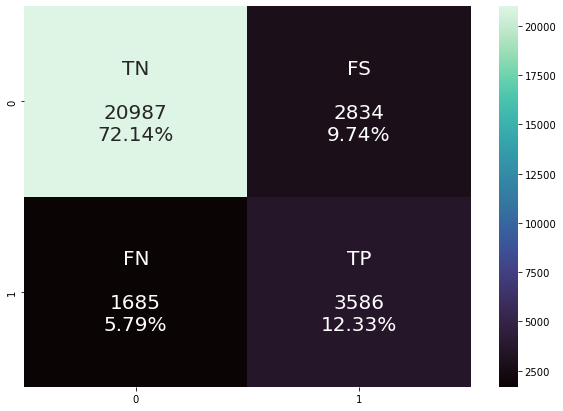

In [ ]:
plot_confusion(model.predict(X_test),y_test)

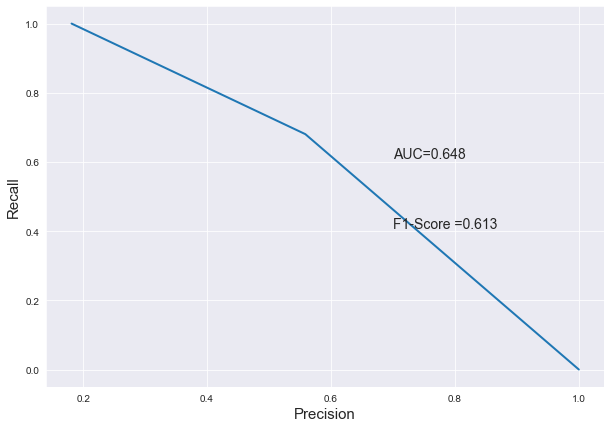

In [ ]:
plot_precisionvsrecall(model.predict(X_test),y_test)

Looks like we couldn't improve AUC that much. Let's now get the best parameters and train the model on the `PolynomialFeatures()` used version of our data to see if we can improve the model further.

In [ ]:
model.best_params_

{'penalty': 'l1',
 'loss': 'squared_hinge',
 'fit_intercept': True,
 'dual': False,
 'C': 10}

Now I will add PolynomialFeatures with degree three to scaleandmerge() function and split the dataset again.

In [ ]:
def scaleandmerge(data):
    numerical_data=PolynomialFeatures(degree=3).fit_transform(data[numerical])
    scaler = StandardScaler()
    numerical_data = scaler.fit_transform(numerical_data)
    numerical_data = pd.DataFrame(numerical_data)
    data.drop(numerical,axis=1,inplace=True)
    data_processed=pd.concat([numerical_data, data],axis=1) 
    return data_processed

In [ ]:
numerical = [features for features in data.columns if data[features].dtype==float]
data_processed=combinedprocessing(data)
data_processed=df_column_uniquify(data_processed)

Transforming in progress...
Transforming completed


In [ ]:
le=LabelEncoder()
target=le.fit_transform(data_processed["RainTomorrow"])
data_processed.drop(["RainTomorrow"],axis=1,inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data_processed, target, test_size = 0.2, random_state = 42)
X_rosfloat, yrosfloat = oversampler_float.fit_resample(X_train,y_train)

Let's train the model. I also add `class_weight` argument to try to improve the result.

In [ ]:
modelfit=LinearSVC(penalty="l1",loss="squared_hinge",fit_intercept=True,dual=False,C=50,class_weight={0:1.3,1:1},max_iter=1500).fit(X_rosfloat,yrosfloat)

In [ ]:
accuracy_score(modelfit.predict(X_test),y_test)

0.8497868829918878

We slightly improved the accuracy, let's also see how F1-Score changed.

<Figure size 720x504 with 0 Axes>

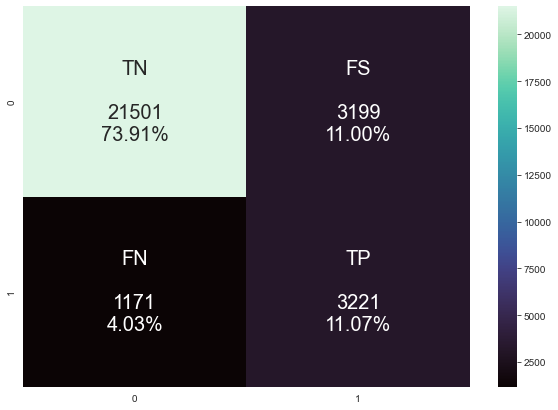

In [ ]:
plot_confusion(modelfit.predict(X_test),y_test)

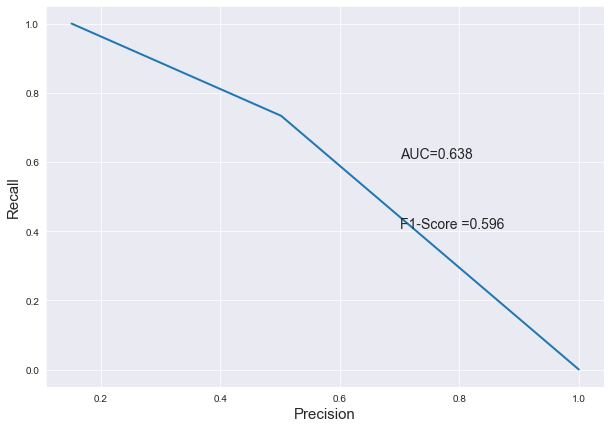

In [ ]:
plot_precisionvsrecall(modelfit.predict(X_test),y_test)

Even though we improved the accuracy score, We got lower F1 and AUC scores. In fact, we can improve the F1 and AUC scores slightly by setting `scoring="f1"` but I will not do that in this notebook. You can try out different combinations to improve model

## Adult Census Income Dataset

Now I will load a famous dataset that we didn't use before. For this dataset, our aim will be to predict median house income. You can find more about this dataset [here](https://archive.ics.uci.edu/ml/datasets/adult).

In [ ]:
data=pd.read_csv("adult.csv")
data.head(5)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Let's get the target feature and drop it from the data frame.

In [ ]:
target=data["income"]
data.drop(["income"],axis=1,inplace=True)

This dataset is also another dataset in which we have a class imbalance problem.

C:\Users\gorke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

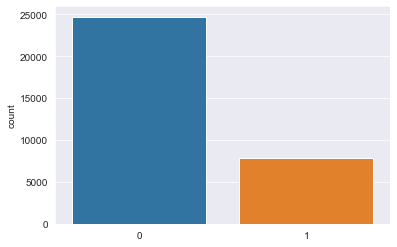

In [ ]:
sns.countplot(target)

Let's get numerical features in the dataset and see if they contain any missing values.

In [ ]:
numerical = [features for features in data.columns if data[features].dtype=='int64']
data[numerical].isnull().sum()

age               0
fnlwgt            0
education.num     0
capital.gain      0
capital.loss      0
hours.per.week    0
dtype: int64

Looks like we don't have any missing value. We can directly use `PolynomialFeatures()` and `StandardScaler()`.

In [ ]:
numerical_pf=PolynomialFeatures(degree=2).fit_transform(data[numerical])

In [ ]:
numerical_scaled=StandardScaler().fit_transform(numerical_pf)
numerical_scaled=pd.DataFrame(numerical_scaled)

Now I will use get dummies to encode the categorical features.

In [ ]:
categorical = [features for features in data.columns if data[features].dtype==object]
data_dummied=pd.get_dummies(data[categorical], columns = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country'])
data_dummied

,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32557,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32558,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32559,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Let's concatenate categorical and numerical features.

In [ ]:
concatenated_array=np.concatenate((data_dummied,numerical_scaled),axis=1)

In [ ]:
predictors=pd.DataFrame(concatenated_array,columns=list(data_dummied.columns)+list(numerical_scaled.columns))

In [ ]:
predictors.head(5)

,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,...,18,19,20,21,22,23,24,25,26,27
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.535093,-0.13662,8.307044,-0.294334,-0.079789,0.0,-0.13498,22.479247,9.291414,-0.172685
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.535093,-0.13662,8.307044,-1.407741,-0.079789,0.0,-0.13498,22.479247,4.067193,-1.346972
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.161847,-0.13662,9.253290,-0.069404,-0.079789,0.0,-0.13498,22.479247,9.291414,-0.172685
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-1.811989,-0.13662,3.179585,-1.418988,-0.079789,0.0,-0.13498,17.978870,8.297072,-0.172685
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.161847,-0.13662,8.262729,-0.069404,-0.079789,0.0,-0.13498,17.978870,8.297072,-0.172685


Now I encode the target feature and split training and testing data.

In [ ]:
le=LabelEncoder()
target=le.fit_transform(target)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size = 0.2, random_state = 42)

In [ ]:
params = {
    'C':[0.50,1,5,10,50],
    'kernel': ["linear","poly","rbf"],
    'gamma': ["scale","auto"],
    'degree':[2,3], 
}

This time I will use `SVC()`. We will use almost the same parameters that we used in the previous notebook for tuning, however, this time I will not add a sigmoid kernel because I don't think it is as effective as much as the others.

In [ ]:
from sklearn.svm import SVC

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rscv_adultincome=RandomizedSearchCV(SVC(), params, cv=10,verbose=2,scoring="accuracy")

In [ ]:
model2=rscv_adultincome.fit(X_train,y_train)

In [ ]:
accuracy_score(model2.predict(X_test),y_test)

0.855366190695532

<Figure size 720x504 with 0 Axes>

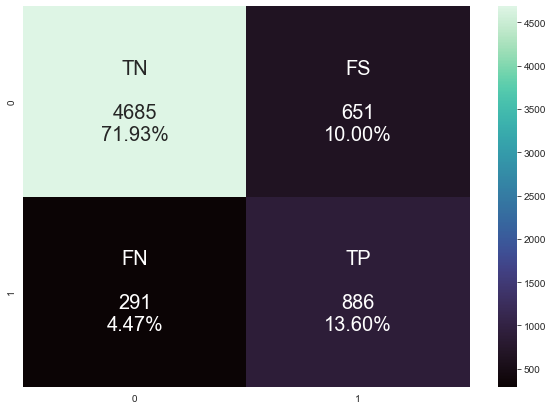

In [ ]:
plot_confusion(model2.predict(X_test),y_test)

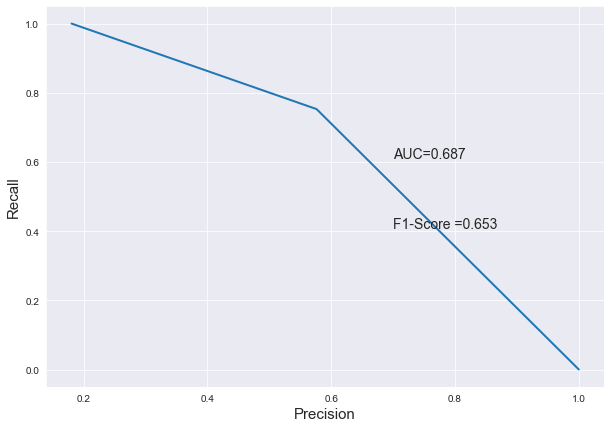

In [ ]:
plot_precisionvsrecall(model2.predict(X_test),y_test)

Even though we didn't use any method to deal with class imbalance, the AUC score looks relatively good.

**Attention:** It may look like I'm just randomly training these models on these datasets, however, my aim is not this. My aim is here actually to show you despite the fact that we used different models what is important is still how good our data is. Of course, we can use more robust methods but the performance of the algorithm is much affected by its data. Instead of really constructing a real model that deals with a class imbalance here. I wanted to show you how the performance would change if we used SVM instead of Logistic Regression. Moreover, I showed another dataset in which we have a class imbalance problem. Think of those models as our baseline models and  I will try to improve these models in the upcoming notebooks.

## Multiclass Classification with SVC on Wine Quality Dataset

Now We will perform multiclass classification on Wine Quality Dataset. This dataset is different than the previous wine dataset we used and here we are trying to predict the quality of wine ranging from 3 to 9.

In [8]:
data=pd.read_csv("winequality.csv")
data.head(5)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Let's separate categorical columns and numerical so that we can use `PolynomialFeatures()` on numerical features and encode categorical ones.

In [9]:
categorical = [features for features in data.columns if data[features].dtype==object]
numerical = [features for features in data.columns if data[features].dtype==float]

In [10]:
target=data["quality"]
winetype=data[categorical]
data.drop(["quality","type"],axis=1,inplace=True)

Let's also use `countplot()` to see if there is class imbalance.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


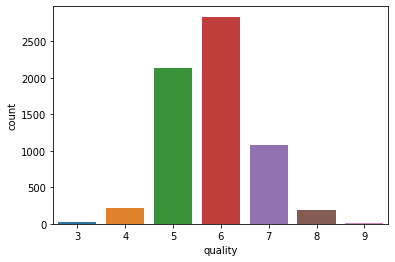

In [11]:
sns.countplot(target)

There is a big class imbalance. I will not use any technique to cope with this problem not to make this notebook even longer. However, I will try to improve the model we will construct in this notebook in upcoming notebooks.

In [12]:
data[numerical].isnull().sum()

fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
dtype: int64

Looks like we also need to use `SimpleImputer()`

In [13]:
from sklearn.impute import SimpleImputer
predictors_numerical=SimpleImputer(strategy='median').fit_transform(data[numerical])

In [14]:
from sklearn.preprocessing import PolynomialFeatures
predictors_pf=PolynomialFeatures(degree=2).fit_transform(predictors_numerical)

In [15]:
from sklearn.preprocessing import StandardScaler
predictors_scaled=StandardScaler().fit_transform(predictors_pf)

In [16]:
predictors=np.concatenate((pd.get_dummies(winetype),predictors_scaled),axis=1)

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size = 0.2, random_state = 42,stratify = target)

I will only use the RBF and linear kernels.

In [18]:
params = [
  {'C': [0.5, 1,  10, 20, 50, 100], 'kernel': ['linear']},
  {'C': [0.5, 1,  10, 20, 50, 100], 'gamma': [0.1, 0.5, 0.75, 1], 'kernel': ['rbf']},
 ]

In [19]:
rscv_wine=RandomizedSearchCV(SVC(gamma="scale"), params, cv=10,verbose=42,scoring="accuracy")

In [ ]:
model1=rscv_wine.fit(X_train,y_train)

In [25]:
model1.best_params_

{'C': 50, 'gamma': 0.5, 'kernel': 'rbf'}

In [26]:
accuracy_score(rscv_wine.predict(X_test),y_test)

0.6338461538461538

The accuracy score is actually better than I expected. However, It is not a good result in general. Let's also plot the confusion matrix and precision-recall curve.

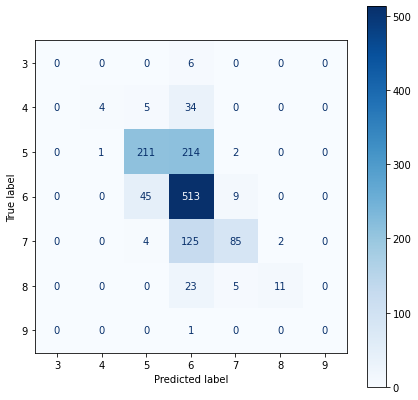

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, rscv_wine.predict(X_test), labels=model1.classes_)
fig, ax = plt.subplots(figsize=(7,7))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_).plot(cmap=plt.cm.Blues,ax=ax)

I will redefine `plot_precisionvsrecall()` so that we can use it for this dataset.

In [23]:
def plot_precisionvsrecall(y,y_pred):
    fpr = dict()
    tpr = dict()
    th  = dict()
    roc_auc = dict()
    
    y_score=label_binarize(y_pred, classes=[3, 4, 5, 6, 7, 8, 9])
    y_test_binarized=label_binarize(y, classes=[3, 4, 5, 6, 7, 8, 9])
    n_classes = y_score.shape[1] 
    if isinstance(y_pred, (np.ndarray)):
        # precision recall curve
        prevsrec_auc=dict()
        precision = dict()
        recall = dict()
        th = dict()

        plt.figure(figsize=(10, 7))
        sns.set_style("darkgrid")

        precision["micro"], recall["micro"], th["micro"] = precision_recall_curve(y_test_binarized.ravel(), y_score.ravel())
        prevsrec_auc["micro"] = auc(recall["micro"], precision["micro"])

        plt.plot(precision["micro"], recall["micro"], lw=2, label='micro-average Precision-Recall curve (area = {0:0.2f})'
                       ''.format(prevsrec_auc["micro"]))
    
        plt.xlim([-0.01, 1.05])
        plt.ylim([-0.01, 1.05])
        plt.xlabel("Precision",fontsize=20)
        plt.ylabel("Recall",fontsize=20)
        plt.legend(loc="lower right",prop={'size': 16})

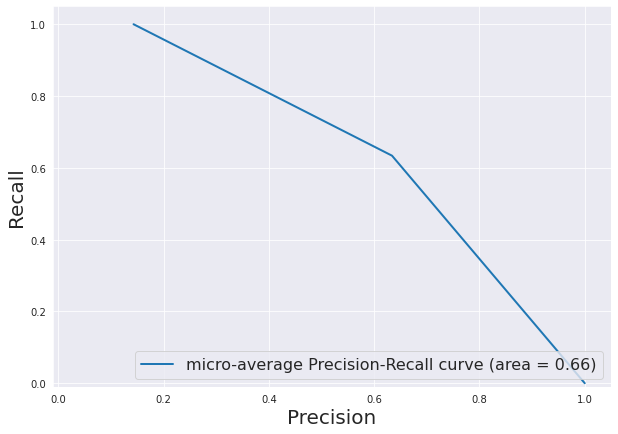

In [24]:
from sklearn.preprocessing import label_binarize
plot_precisionvsrecall(y_test, rscv_wine.predict(X_test))

Let's also use the OveVsRest strategy to see if it will perform better.

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
model_onevsrest=OneVsRestClassifier(SVC(gamma="scale"))

In [ ]:
params2 = [
  {'estimator__C': [0.5, 1,  10, 20, 50, 100], 'estimator__kernel': ['linear']},
  {'estimator__C': [0.5, 1,  10, 20, 50, 100], 'estimator__gamma': [0.1, 0.5, 0.75, 1], 'estimator__kernel': ['rbf']},
 ]

In [ ]:
rscv_wine2=RandomizedSearchCV(model_onevsrest, params2, cv=10,verbose=42,scoring="accuracy")

In [ ]:
model2=rscv_wine2.fit(X_train,y_train)

In [ ]:
accuracy_score(rscv_wine2.predict(X_test),y_test)

0.6515384615384615

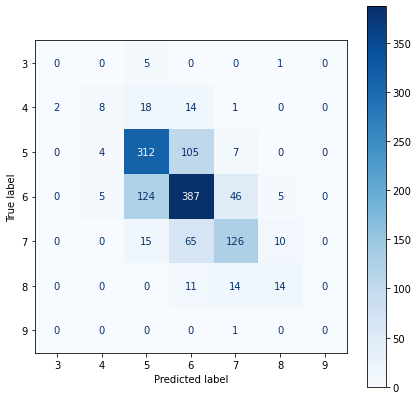

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, rscv_wine2.predict(X_test), labels=model2.classes_)
fig, ax = plt.subplots(figsize=(7,7))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_).plot(cmap=plt.cm.Blues,ax=ax)

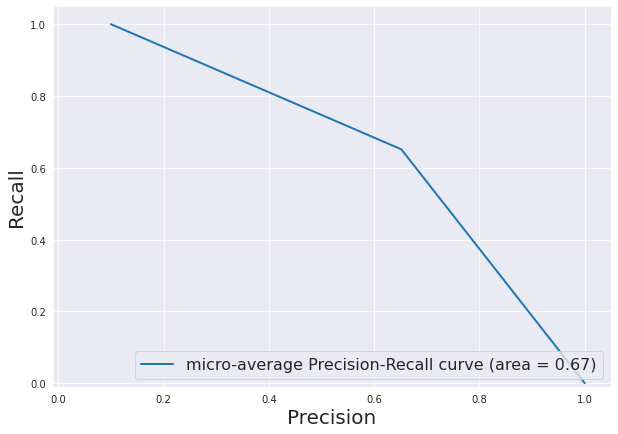

In [ ]:
from sklearn.preprocessing import label_binarize
plot_precisionvsrecall(y_test, rscv_wine2.predict(X_test))

In [ ]:
rscv_wine2.best_params_

{'estimator__C': 10, 'estimator__gamma': 0.1, 'estimator__kernel': 'rbf'}

The one-vs-Rest strategy looks slightly performing better but there is not much performance difference between them. I will improve the models in this notebook further in another notebook.